<a href="https://colab.research.google.com/github/stdm/ZHAW_deep_voice/blob/master/planning_with_reasoning_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Complex prompting strategies for LLMs and reasoning models

In this lab, we will use a vanilla LLM (not fine-tuned for reasoning) and a reasoning model (fine-tuned for reasoning).

First, we will set up technical aspects we require.
LLM models are usually hosted on separate servers (here, a separate process) and not loaded by each Python script due to their size.

**Ollama** is a tool that enables the hosting of different large language models. So, the setup is depicted below. We start Ollama in a separate process and call it from Colab. Starting an extra process in Colab required us to start an extra console. Read the setup below carefully to not miss any step.

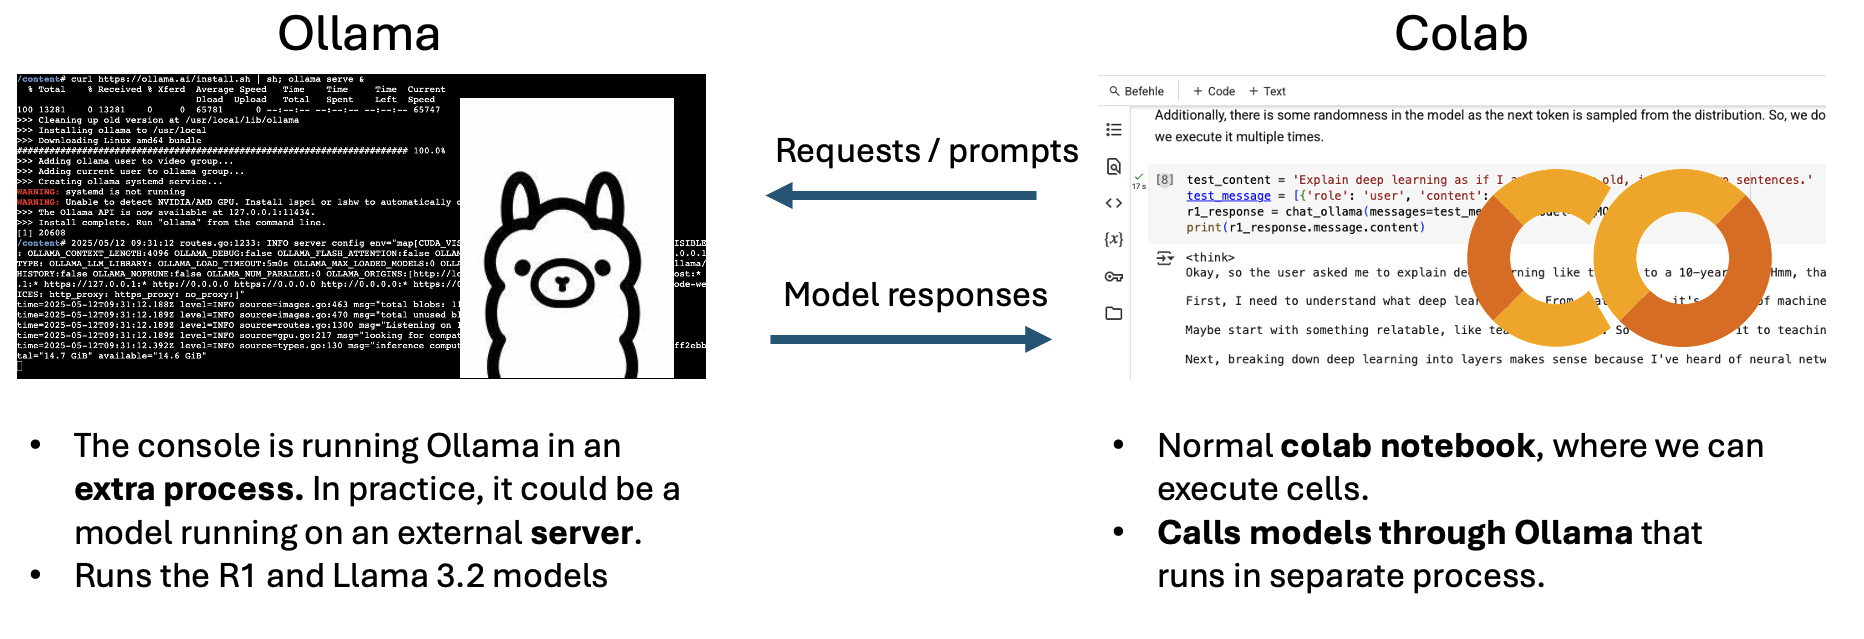


## Technical Setup - CoLab (Recommended)

1. Switch runtime to `T4 GPU` under `Runtime -> Change runtime type` as shown in [this video](https://www.youtube.com/watch?v=6H381fUOolU&t=2s).
2. Follow the cells in 'Start Ollama in Colab'. Careful, **you can't run all cells as we have to start ollama manually in a separate process (console)**.

## Technical Setup - Local (GPU required)

1. Install [Ollama](https://ollama.com/download)
2. Run Ollama
3. Skip the 'Start Ollama in Colab' cells, and run locally


## Start Ollama in Colab

Ollama has to run in a separate process. To do this in Colab, we use the colab-xterm Plugin, which runs an interactive console in a **separate process**. In that console, we install and run ollama.

Source: https://medium.com/@abonia/running-ollama-in-google-colab-free-tier-545609258453

Follow this steps carefully to start Ollama in Colab:

1. **Run the next code cell** to start a console inside the Colab environment. After a few seconds, a console window starting with '/content#' should appear.
2. **In that console, put in the command**:
`
curl https://ollama.ai/install.sh | sh; ollama serve &
` to (install and) start ollama in that console.
3. **Wait** around _one minute_ until Ollama is started. Then, you can start running the rest of the jupyter notebook.

In [ ]:
!pip install colab-xterm
%load_ext colabxterm

# curl https://ollama.ai/install.sh | sh; ollama serve &
%xterm

Here, we **check if the installation worked**.

4. Run this cell. It should display `ollama version is 0.6.8` (or newer). It should **not** show any Warning that Ollama has not started. For example, if you get, "Warning: could not connect to a running Ollama instance," you didn't start Ollama correctly; maybe it is still starting up (see previous cell).

In [ ]:
!ollama --version

## Task 1: Prepare models we require

We use:
* **deepseek-r1:7b:** DeepSeek R1 is a large language model with explicit reasoning fine-tuning - such models are called **reasoning model**. The ":7b" stands for the **7 billion parameter** version. This is a huge model for us, yet it is the smallest available model in terms of foundation models. It was produced using [distillation](https://pytorch.org/blog/llama-into-torchtune/) from the bigger deep seek model. Note that bigger models perform better than smaller models but would require a multi-GPU setup.
* **llama3.2:3b:** LLama 3.2 is a large language model without explicit reasoning fine-tuning - we call this **vanilla LLM**. The ":3b" stands for the **3 billion parameter** version. Again, a distillation from a bigger model.

Look at the output when pulling those models later. You should be able to see that they are many **GB** big, showing the vast amount of parameters (3 or 7 *billion*) they contain.

### Setup Ollama

First, we set up the Ollama Python package and a basic function for communicating with the Ollama process.

In [ ]:
!pip install ollama

In [ ]:
import ollama
def chat_ollama(messages,model,tools=None):
    response = ollama.chat(
        model=model,
        messages=messages,
        tools=tools
    )
    return response

In [ ]:
import copy
import json

R1_MODEL = 'deepseek-r1:7b' # reasoning model (our planner)
LLAMA_MODEL = 'llama3.2:3b' # vanilla LLM (our plan executer)

### Prepare R1 for the Lab

Next, we pull `deepseek-r1:7b`, our **reasoning model**, and validate that it is running.

In [ ]:
!ollama pull deepseek-r1:7b

Execute the next cell. In the output, we see the **reasoning chain** inside the `<think> ... </think>` tags and the actual answer afterward. In ChatGPT, Claude, and Geminiusually hide the reasoning chain from the user, as the tokens are internal thinking steps (System 2 Thinking).

The thinking **breaks down the problem** step by step, for example, analyzing the task at hand. Be **careful not to anthropomorphize the reasoning steps**. For example, we got `Hmm... Let's break this down.` as part of the reasoning chain. This is an **artifact of the training** and web data and does not help the model to improve the answer.

Additionally, the model has some randomness as it samples the next token. So, we do **not get the same answer** if we execute it multiple times.

In [ ]:
test_content = 'Explain deep learning as if I am a 10 year old, in one to two sentences.'
test_message = [{'role': 'user', 'content': test_content}]
r1_response = chat_ollama(messages=test_message, model=R1_MODEL)
print(r1_response.message.content)

### Prepare Llama 3.2 for the Lab

Next, we pull `llama3.2:3b`, our **vanilla LLM**, and validate that it is running.

In [ ]:
!ollama pull llama3.2:3b

Execute the next cell. In the output, we see no reasoning chain as llama 3.2 is no reasoning model, meaning it puts out the answer without intermediate "thoughts".

In [ ]:
test_prompt = 'Explain deep learning as if I am a 10 year old, in one to two sentences.'
test_message = [{'role': 'user', 'content': test_prompt}]
llama_response = chat_ollama(messages=test_message, model=LLAMA_MODEL)
print(llama_response.message.content)

* **Exercise 1.1**: What is the difference between the `R1` model and the `Llama` model? Think **mechanically**: What is different in their execution (see cells above)? Think **conceptually**: Why do they differ in that way (see slides)?
* **Exercise 1.2**: Experiment with the models by **changing the `test_prompt`**. For example, try a reasoning puzzle and see if you can observe a capability difference. **Write down** your experiments and results (screenshot) for the lab discussion. For example, [this](https://simple-bench.com/try-yourself) provides some reasoning tasks as inspiration. Try to find **similar or make up a reasoning task yourself**. Be aware that online resources are probably part of the initial training data; hence, solving such tasks could be memorized by the model. Note that `R1` can take **several minutes** for more complex prompts as it is free to use up as much test time computation as necessary.

## Task 2: Tool usage

Large language models can **use tools using zero-shot or few-shot learning**:
In the prompt, we explain the available tools and document the API.
The LLM can utilize the tools by generating text that follows the API definition.
An intermediate logic then maps this generated text to actual API calls.
This is a typical pattern and is **already implemented in Ollama**.
Therefore, we only must provide the tools in the `tools` parameter.
The orchestration between LLM and tools happens inside Ollama.

In this task, we make a minimal example using a tool that can add two numbers.
Note that we use the vanilla LLM `LLama 3.2` (no reasoning model).
Specifically, we do the following:
1. We **define a simple tool** that adds two numbers.
2. We **pass** this tool to ollama.
3. The LLM model is informed (by ollama) about this tool and checks if the LLM triggers a call to that tool. If so, it **returns the call** in `response.message.tool_calls`.
4. We loop over all predicted tool calls and **execute** them.

Note that in practical applications, you could provide more tools, for example, all end-points of an internal REST API.

* **Exercise 2.1**: Study the code carefully. You should understand each step.
* **Exercise 2.2**: What happens if we change the `user_prompt` to `What is 42 + 23 + 56 + 33?`? Validate the result manually. Different failure modes exist, so execute the cell multiple times (e.g., 10 times). Why is the result wrong? Where does the error occur? Why does this happen?


In [ ]:
import ollama

# 1. Here we define the tool add_two_numbers
def add_two_numbers(a: int, b: int) -> int:
    """
    Add two numbers

    Args:
      a: The first integer number
      b: The second integer number

    Returns:
      int: The sum of the two numbers
    """
    return int(a) + int(b)

user_prompt = 'What is 10 + 10?'                # Exercise 1
user_prompt = 'What is 42 + 23 + 56 + 33?'    # Exercise 2

# 3. (hidden inside ollama)
response = ollama.chat(
    LLAMA_MODEL,
    messages=[{'role': 'user', 'content': user_prompt}],
    tools=[add_two_numbers],  # 2. here we pass the tool to ollama
)

# 4. Here we execute the predicted tool calls
available_functions = {
    'add_two_numbers': add_two_numbers,
}
for tool in response.message.tool_calls or []:
    print(tool)
    function_to_call = available_functions.get(tool.function.name)
    if function_to_call:
        print('Function output:', function_to_call(**tool.function.arguments))
    else:
        print('Function not found:', tool.function.name)

### Task 3: Planning with tool usage

One use case for **reasoning models** such as `R1` is **creating a plan** to solve a task given a set of **tools** to carry out the plan and constraints to set bounds around the task. This kind of use case would be very slow if we used `R1` for every step, so we'll generate a plan with `R1-7b` and then execute each step with `llama3.2-3b`.

To make planning necessary, we make the last example more complex by adding **more sophisticated tools**.
Specifically, we do the following:

1. Add **more sophisticated tools**.
2. Add a scenario description to provide a more **detailed prompt** to help the models.
3. Prompt the reasoning model `R1` to **create a plan**.
4. Prompt the vanilla LLM `Llama` to **execute the plan** by predicting individual tool usage.
5. **Run** the predicted tool operations and print the result.

Note that we use general LLMs here despite this being a simple toy task. Thus, you can apply the shown concepts to a broad range of (more complex) tasks.

* **Exercise 3.1**: Study the code carefully. You should understand each step.
* **Exercise 3.2**: Change the `scenario` prompt. Try removing it. Try changing it to another scenario. What do you observe?
* **Exercise 3.3**: Remove the planer step, e.g., by not passing the plan to the Llama model. What do you observe?


In [ ]:
stack = []

# 1.
def sum_stack():
    """
    Operates on the global 'stack' data structure.
    Calculates and returns the sum of all integer values currently present on the stack.

    Args: None
    Returns:
      float: The sum of all integer values popped from the stack.
             The stack will be empty after this operation.
    """
    sum = 0.0
    while len(stack) > 0:
      sum += int(stack.pop())
    return sum

# 1.
def put_on_stack(a: int):
    """
    Operates on the global 'stack' data structure.
    Pushes an integer value onto the top of the stack.

    Args:
      value: The integer to be added to the top of the stack.

    Returns: None
    """
    stack.append(a)
    return

user_prompt = "What is 42 + 23 + 56 + 33?"

# 2.
scenario = """
The user is interacting with a system that can perform calculations using a stack-based approach.
The system has two primary functions: 'put_on_stack' which adds a number to a temporary memory stack, and 'sum_stack' which calculates the sum of all numbers currently on the stack and then clears the stack.
The user wants to find the total of a series of numbers.
Use the available functions to solve this task reliably.
"""

# 3.
r1_prompt = f"""
Scenario:
{scenario}

You are the planner, that plans how to solve the user query using the available functions.

User query: {user_prompt}

To solve this problem, we have access to two functions that operate on a stack data structure:

1.  **put_on_stack(value: int):** This function takes an integer as input and adds it to the top of the stack.

2.  **sum_stack():** This function calculates and returns the sum of all integer values currently present on the stack. Importantly, after calculating the sum, this function will empty the stack.

Given these functions, describe a step-by-step plan to calculate the sum of the user query.
"""
r1_response = ollama.chat(
    R1_MODEL,
    messages=[{'role': 'user', 'content': r1_prompt}],
)
plan = r1_response.message.content
print(f"Plan: {plan}")

# 4.
llama_prompt = f"""
Scenario:
{scenario}

You are the executer, that executes the plan of a smarter model.
You should blindly follow the proposed plan step-by-step. Do not skip a step. Do not forget to execute a step. Use your tools to execute each steps.

User query: {user_prompt}

Plan: {plan}
"""

response = ollama.chat(
    LLAMA_MODEL,
    messages=[{'role': 'user', 'content': llama_prompt}],
    tools=[put_on_stack, sum_stack],  # 2. here we pass the tool to ollama
)

# 5.
available_functions = {
    'sum_stack': sum_stack,
    'put_on_stack': put_on_stack,
}
print(response.message)
for tool in response.message.tool_calls or []:
    print(tool)
    function_to_call = available_functions.get(tool.function.name)
    if function_to_call:
        print('Function output:', function_to_call(**tool.function.arguments))
    else:
        print('Function not found:', tool.function.name)

# Task 4: Open-Ended Challenge

Do something awesome with the concepts shown above, for example:

* Create a **more complex scenario** than just adding numbers. Let `R1` create a plan, and then `Llama` execute the plan. If the scenario fails, try to find the model causing the problem. Does the planner fail, or does the execution fail?
An example of a very complex scenario can be found [here](https://learn.deeplearning.ai/courses/reasoning-with-o1/lesson/km468/planning-with-o1).
* Experiment with **different prompts**. Document what works and what does not work.
* Expand on the **limitations of the vanilla LLM** `Llama 3.2` compare to the reasoning model `R1` (end of task 1). Can we detect a difference in quality empirically on different example tasks?